In [109]:
%load_ext autoreload
%autoreload 2

from rejax.evaluate import evaluate
import jax
import numpy as np
from env import EnvParams, NavigationEnv
from models.mlp import MLP
from criteria.ppo import PPO
from criteria.gaussian_policy import GaussianPolicy
from rooms import RoomParams, generate_rooms
# from src.models import MLP

TRAIN_SEED = 11

# Initialize our environment
env = NavigationEnv()

# Generate rooms
room_params = RoomParams(
    size=4.0,
    grid_size=8,
    target_carved_percent=0.5,
    num_rooms=256,
)
room_key = jax.random.PRNGKey(TRAIN_SEED)
obstacles, free_positions = generate_rooms(room_key, room_params)

# Initialize environment parameters with generated rooms
env_params = EnvParams(
    lidar_max_distance=2.0,
    lidar_fov=120,
    lidar_num_beams=16,
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
)

# Initialize the training algorithm parameters
config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": env_params,
    # Number of timesteps during which the agent will be trained
    "total_timesteps": 1_000_000,
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**config)

# Look at the whole configuration (we can experiment with all these parameters!)
ppo.config



import flax.linen as nn
from jax import numpy as jnp




# actor = CPolicy(MLP([128, 128, 2]))
actor = GaussianPolicy(2, (np.array([-1., -1.]), np.array([1., 1.])), MLP([128, 128, 2]))
# critic = VNetwork(MLP)([128, 128, 1])
ppo = ppo.replace(actor=actor)\

ppo.config







import jax
import time

# Set the seed for reproducibility
TRAIN_SEED = 13

# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting to train
Traced<ShapedArray(float32[1,40])>with<DynamicJaxprTrace>
(1, 40)
Traced<ShapedArray(float32[1,40])>with<DynamicJaxprTrace>
(1, 40)
(Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace>, Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace>)
Traced<ShapedArray(float32[64,40])>with<DynamicJaxprTrace>
(64, 40)
LOGS Traced<ShapedArray(float32[64,2])>with<DynamicJaxprTrace> Traced<ShapedArray(float32[64,128])>with<DynamicJaxprTrace> Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace>
Traced<ShapedArray(float32[256,40])>with<DynamicJaxprTrace>
(256, 40)
Traced<ShapedArray(float32[1,40])>with<DynamicJaxprTrace>
(1, 40)
Finished training in 42.4996 seconds (23529.6 steps/second).


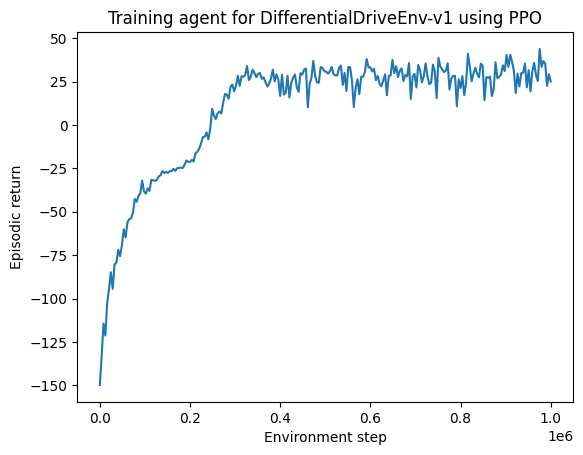

In [110]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()

Running 10 episodes and collecting frames...
Traced<ShapedArray(float32[1,40])>with<DynamicJaxprTrace>
(1, 40)
(Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace>, Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace>)
  Episode 1 finished after 38 steps.
  Episode 2 finished after 38 steps.
  Episode 3 finished after 34 steps.
  Episode 4 finished after 23 steps.
  Episode 5 finished after 49 steps.
  Episode 6 finished after 38 steps.
  Episode 7 finished after 38 steps.
  Episode 8 finished after 41 steps.
  Episode 9 finished after 25 steps.
  Episode 10 finished after 107 steps.
Finished 10 episodes. Total steps: 431. Total frames: 431.
Saving GIF...
GIF saved to temp/navigation_policy.gif


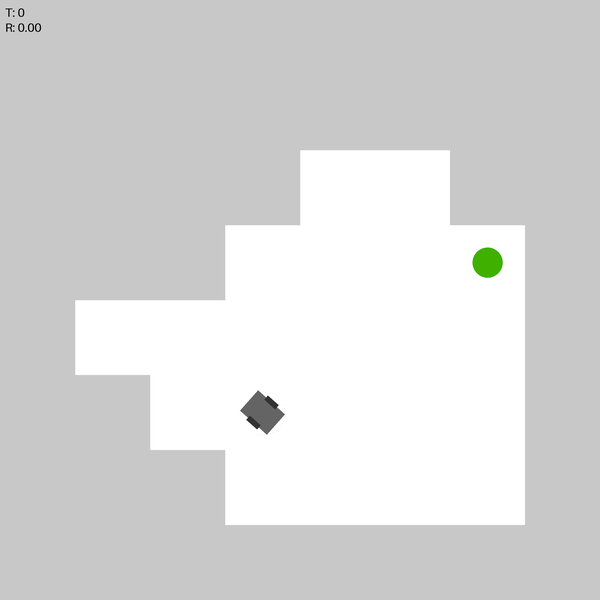

GIF saved as temp/navigation_policy.gif


In [111]:
from IPython.display import Image as IPImage, display
import env_vis
import os

# --- Configuration ---
N_EPISODES = 10  # Number of episodes to run
TEST_SEED = 43


# --- 1. Get Agent ---
t0 = time.time()
act = jax.jit(ppo.make_act(train_state))
key = jax.random.PRNGKey(TEST_SEED)

# List to store frames for GIF
frames = []
total_steps = 0  # Keep track of total steps across episodes

print(f"Running {N_EPISODES} episodes and collecting frames...")

# --- 3. Run Episodes & Collect Frames ---
for i_episode in range(N_EPISODES):
    key, reset_key = jax.random.split(key)
    obs, state = env.reset(reset_key, env_params)
    done = False
    episode_steps = 0

    while not done:
        # Render current state to frame
        frame = env_vis.render_frame(state, env_params)
        frames.append(frame)

        # Choose action and step environment
        key, act_key, step_key = jax.random.split(key, 3)
        action = act(obs, act_key)
        obs, state, _, done, _ = env.step(step_key, state, action, env_params)
        episode_steps += 1

    print(f"  Episode {i_episode + 1} finished after {episode_steps} steps.")
    total_steps += episode_steps

print(f"Finished {N_EPISODES} episodes. Total steps: {total_steps}. Total frames: {len(frames)}.")

# --- 4. Save and Display GIF ---
print("Saving GIF...")
os.makedirs("temp", exist_ok=True)
gif_filename = "temp/navigation_policy.gif"
env_vis.save_gif(frames, gif_filename, duration_per_frame=env_params.dt)

# Display the GIF in the notebook
display(IPImage(filename=gif_filename))
print(f"GIF saved as {gif_filename}")